In [1]:
from IPython.display import HTML, display, Image

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
#pd.set_option("max_columns", None) # show all cols
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
pd.options.display.max_seq_items = 200000
pd.options.display.max_rows = 400000


# End to end selection (short version)

In this tutorial we showcase how to design probesets and select a suitable gene set with the ```spapros``` package. 
For all genes we design probes that fulfill experiment specific requirements and select only genes for which we can design sufficient probes. 
Spapros then selects genes that can distinguish the cell types in the data set and capture transcriptomic varation beyond cell type labels.
The final probe sequences are designed in a last step for all selected genes.
The figure below gives and overview on the pipeline.

In this tutorial the full probe design is performed with one cli command. To understand the different steps in the pipeline we recommend to have a look at the [long version](spapros_tutorial_end_to_end_selection.ipynb) of this tutorial. 

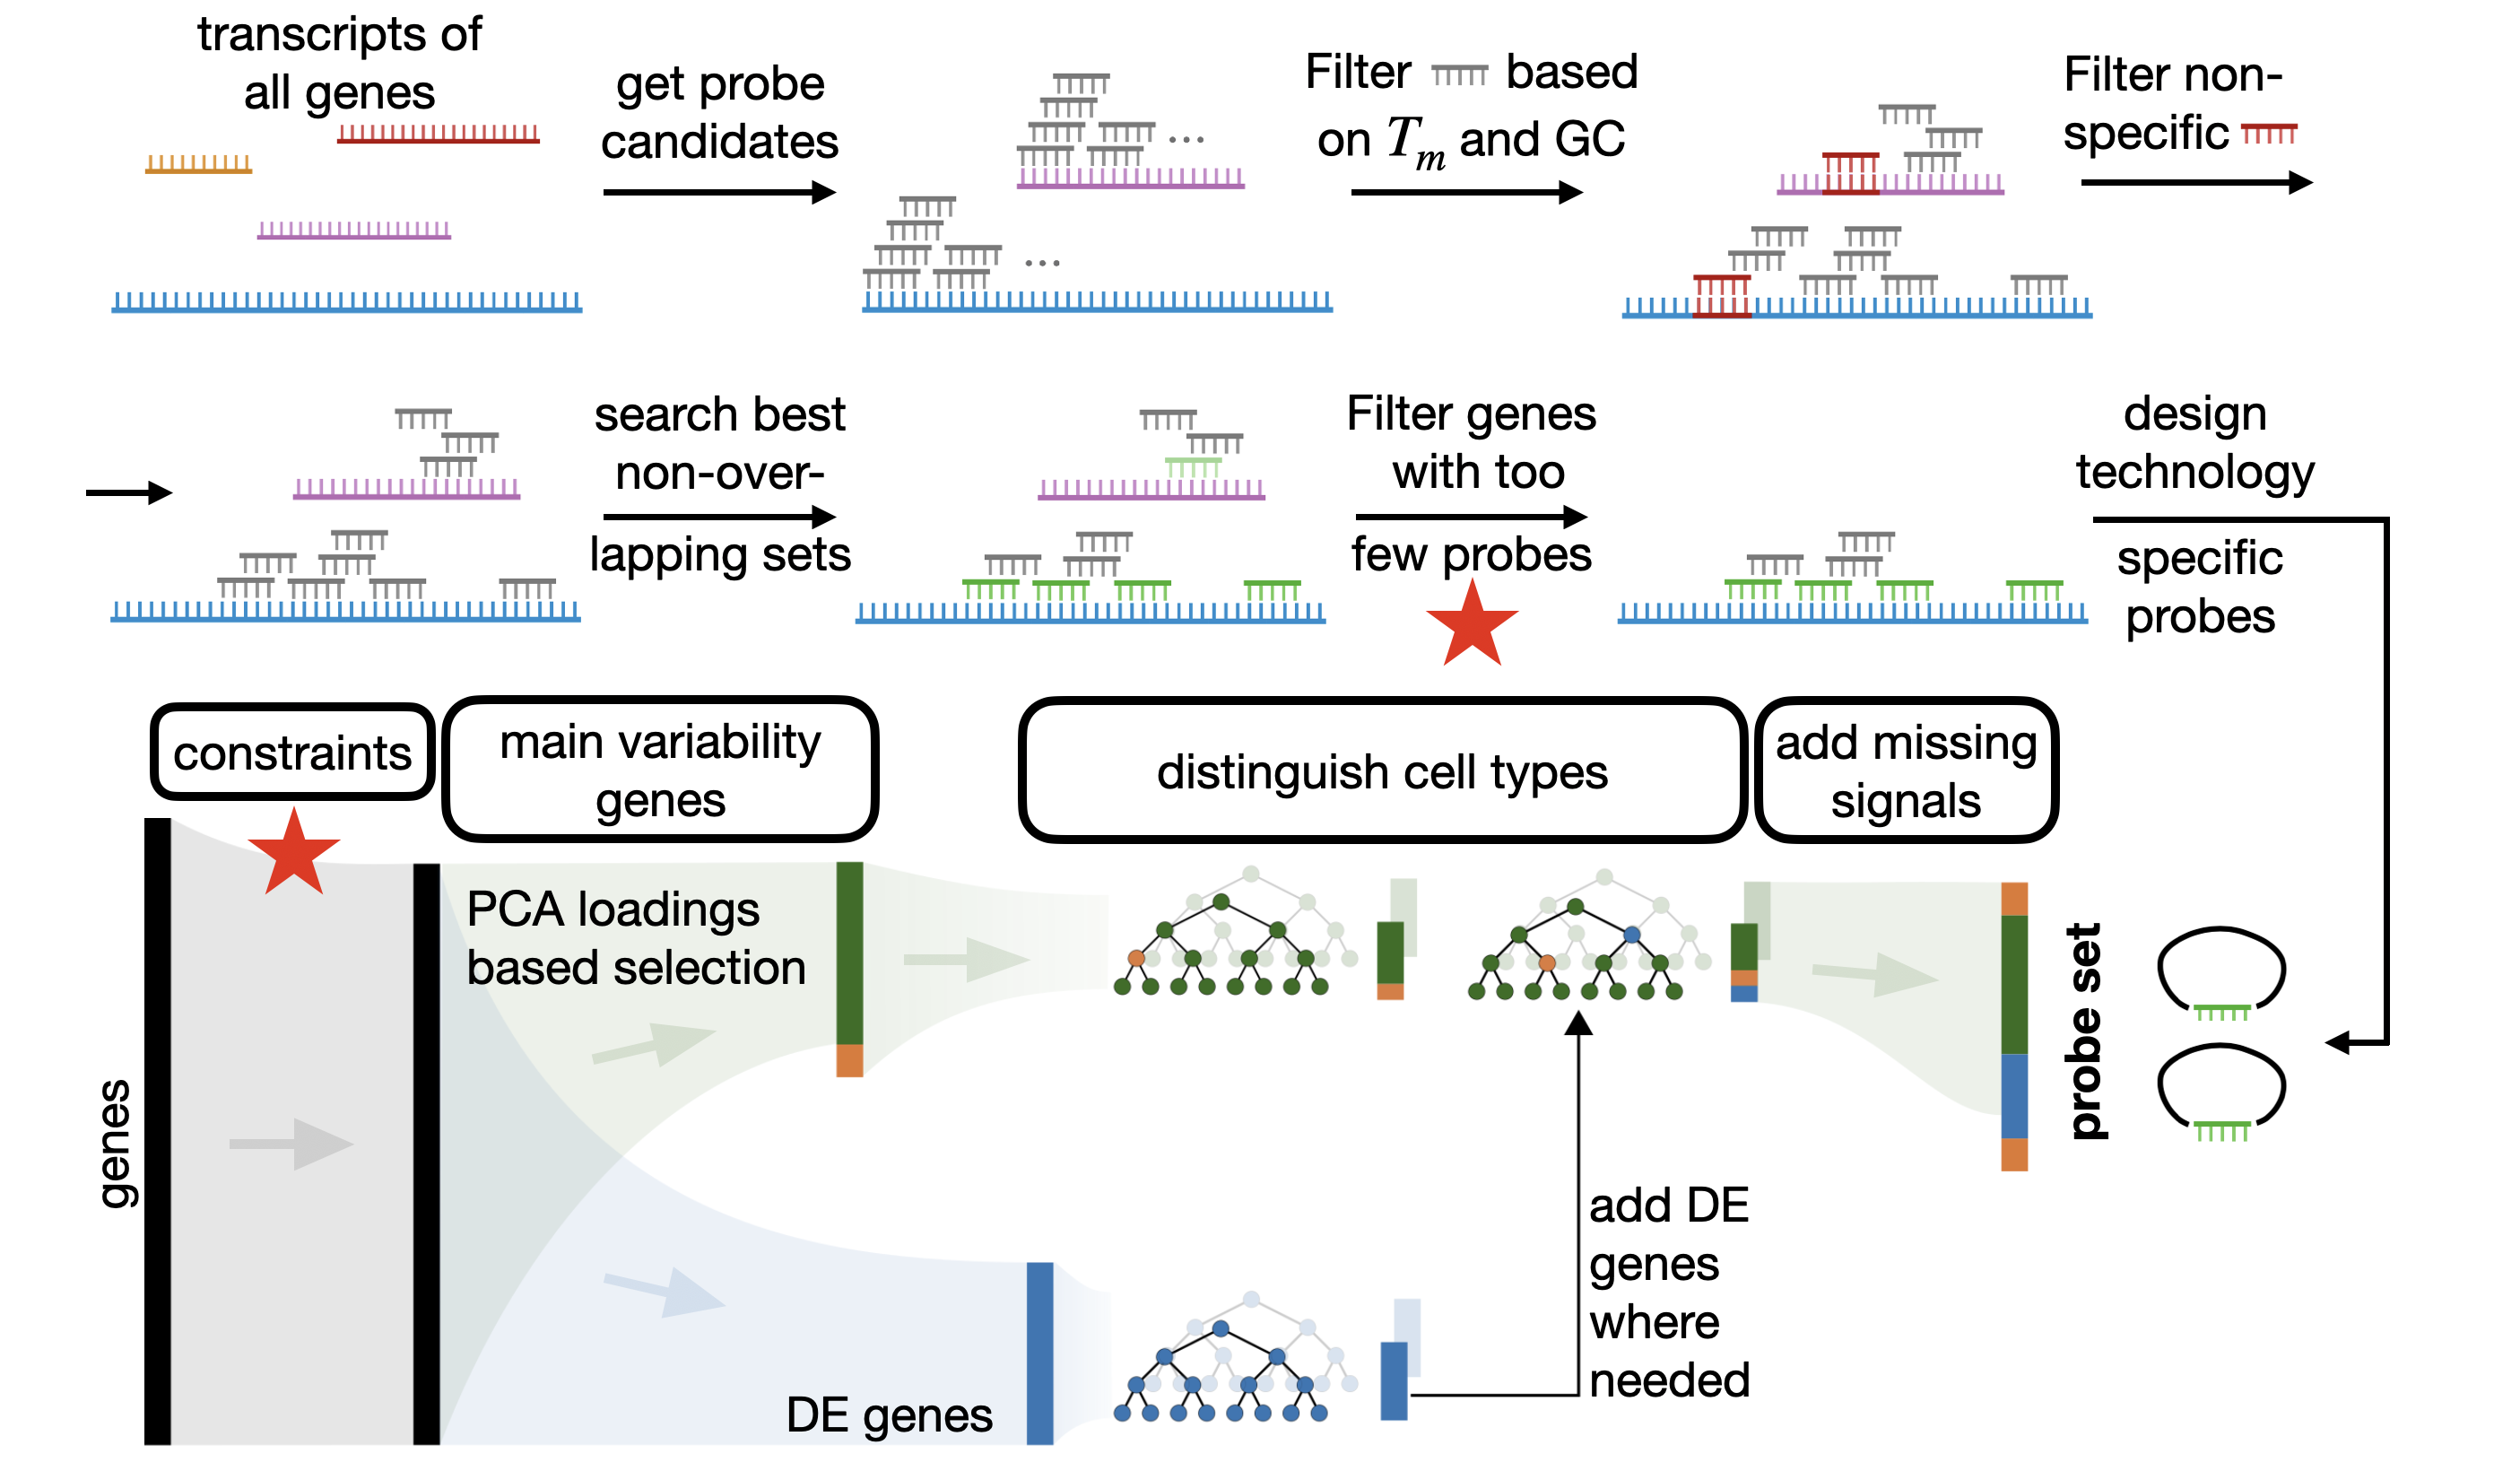

In [ ]:
Image("../_tutorials/abstract_figures/end_to_end.png", width=900, embed=True)

## Import Packages

Besides `spapros` also install `oligo_designer_toolsuite` if not done already. First we need to install some dependencies:

```bash
conda config --add channels bioconda
conda config --add channels conda-forge
conda update conda
conda update --all

conda install "blast>=2.12"
conda install "bedtools>=2.30"
conda install "bowtie>=1.3.1"
conda install "bowtie2>=2.5"
```


To run the code below we need to install the current dev version of the oligo designer:

```bash
git clone https://github.com/HelmholtzAI-Consultants-Munich/oligo-designer-toolsuite.git
cd oligo-designer-toolsuite
git switch pipelines
pip install -e .
```

Otherwise, if that didn't work, try:
```bash
pip install oligo_designer_toolsuite
```

In [2]:
import yaml
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 0
sc.logging.print_header()

import spapros as sp
print(f"spapros=={sp.__version__}")

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.11.2 pandas==1.5.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.9.11 pynndescent==0.5.10
spapros==0.1.3


## Load and Preprocess Data

For this tutorial, we use a PBMC example scRNA-seq reference dataset. 
The count data should be log-normalised and genes should **not** be scaled to mean=0 and std=1. 
We can load the processed version of the data, including cell / gene filters, cell type annotations, and the umap embedding, directly with ```sp.ut.get_processed_pbmc_data()``` function. 
For a step by step processing of the PBMC dataset please refer to the [basic usage tutorial](./spapros_tutorial_basic_selection.ipynb). 
For sake of simplicity, we pre-select the top 1000 highly variable genes for the probe and geneset selection. In real world applications we typically go for top 8000 genes. 

In [3]:
adata = sp.ut.get_processed_pbmc_data(n_hvg=1000)
highly_variable_genes = sorted(adata.var.loc[adata.var['highly_variable']].index.tolist())
print(f"Number of highly variable genes: {len(highly_variable_genes)}")

Number of highly variable genes: 1000


In [17]:
# Save genes as a list in ./my_genes.txt
pd.DataFrame(highly_variable_genes).to_csv('./my_genes.txt', index=False, header=False)

## Probe Design

To conduct the probe design, run the `<technology>_probe_designer` cli command of the oligo-designer-toolsuite from the terminal:

```bash
scrinshot_probe_designer --file_genes ./my_genes.txt -o ./output --n_jobs 2 --min_probes_per_gene 3 --source ncbi --taxon vertebrate_mammalian --species Homo_sapiens --annotation_release 110
```

Alternativ pipelines: `merfish_probe_designer`, `seqfish_probe_designer` (see our [resource table](https://www.google.com/url?q=https://docs.google.com/spreadsheets/d/1NCDLscdmzn32U7_IKy6OKYHqfECn76x0pAD3KFhuJgQ/edit%23gid%3D0&sa=D&source=docs&ust=1692975800552487&usg=AOvVaw20CRwiObnVkWVS54CcqXMq) for an overview of differences between the technologies)

More info can be obtained with 
```bash
scrinshot_probe_designer --help
```

Also note that when running the pipeline, a file `./output/config_scrinshot_ncbi.yaml` is created. It contains all parameters that define the pipeline run. Except of the paramters that define the species and annotation release it makes sense to keep the default parameters. In the [long version](spapros_tutorial_end_to_end_selection.ipynb) of this tutorial the parameters for each pipeline step are described.

## Load probe design filter and run gene panel selection

In [15]:
##### Load probe design filter #####
genes_without_enough_probes = pd.read_csv('./output/regions_with_insufficient_oligos.txt', index_col=0, sep="\t").index.tolist()
adata.var["has_enough_probes"] = [g not in genes_without_enough_probes for g in adata.var_names]
adata.var["pass_constraints"] = adata.var["has_enough_probes"] & adata.var["highly_variable"]

##### Select genes for gene panel #####
selector = sp.se.ProbesetSelector(adata, n=20, genes_key="pass_constraints", celltype_key="celltype", verbosity=1, save_dir=None)
selector.select_probeset()
selected_genes = selector.probeset.index[selector.probeset.selection]

##### Get probes of genes #####
with open('./output/padlock_sequences/padlock_probes_order.yml', 'r') as file:
    all_probes = yaml.safe_load(file)
    probes = {g: all_probes[g] for g in selected_genes}

In [22]:
probes["AAGAB"]

{'AAGAB_oligo1': {'padlock_probe_full_sequence': 'ATCATCACCTCAGGTAACCTCCTCTATGATTACTGACTGCGTCTATTTAGTGGAGCCAAACCTATCTTCTTTCACTCTATCGCAGACCAAG',
  'detection_probe_sequence': 'GCAGACCAAGATCAUCACCU[fluorophore]'},
 'AAGAB_oligo2': {'padlock_probe_full_sequence': 'GTGTGAGCCTTATTTCTTTCTGTCCTCTATGATTACTGACTGCGTCTATTTAGTGGAGCCAAACCTATCTTCTTTGGTAGTGTCTGGAGGG',
  'detection_probe_sequence': '[fluorophore]UCTGGAGGGGUGTGAGCC'},
 'AAGAB_oligo3': {'padlock_probe_full_sequence': 'GAGAGGGATTCAGTACTATCTGTCCTCTATGATTACTGACTGCGTCTATTTAGTGGAGCCAAACCTATCTTCTTTACCACCCCGATGATCA',
  'detection_probe_sequence': 'CCGATGAUCAGAGAGGGATUC[fluorophore]'},
 'AAGAB_oligo4': {'padlock_probe_full_sequence': 'CTAGAAGAGGCCAATATCCCTCCTCTATGATTACTGACTGCGTCTATTTAGTGGAGCCAAACCTATCTTCTTTGACCTTCATCCCATATGTCC',
  'detection_probe_sequence': '[fluorophore]CCAUATGTCCCUAGAAGAGGC'},
 'AAGAB_oligo5': {'padlock_probe_full_sequence': 'ATCACAGTGAGGGCTAATGTCCTCTATGATTACTGACTGCGTCTATTTAGTGGAGCCAAACCTATCTTCTTTCAGAGCCACAGCAGTAATG',
  'det